# Demo 4: ROC 曲线对比（ProteinBERT vs PSSM1110 vs Fusion_PSSM1110 seed=22）

本 demo 复现 full experiment 中 **Fusion_PSSM1110, seed=22** 的设置：
- 只用 **ProteinBERT**（与 `Baseline_head_two_layer` 相同结构）
- 只用 **1110 维 PSSM 特征**（与 `Ablation_RPSSM_1110` 同一套特征）
- **ProteinBERT + PSSM1110 late-fusion**（与 `Fusion_PSSM1110` 使用相同 `FusionTrainConfig`，seed=22）

三种模型均在相同的 **train/valid/test 划分** 上训练/评估，并在 **测试集** 上绘制 ROC 曲线，用于直观对比区分 Acr / Non-Acr 的能力。

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 仅用 GPU1，避免 GPU0 显存已满导致 OOM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from tensorflow import keras

from proteinbert import (
    load_anticrispr_with_ids,
    load_pretrained_model,
    OutputType,
    OutputSpec,
    FinetuningModelGenerator,
    FusionTrainConfig,
    load_feature_cache,
    attach_pssm_features,
)
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
from proteinbert.pssm_fusion import _build_late_fusion_model, _encode_x, find_best_threshold

PROJECT_ROOT = '/home/nemophila/projects/protein_bert'
BENCHMARKS_DIR = os.path.join(PROJECT_ROOT, 'anticrispr_benchmarks')
WORK_ROOT = os.path.join(PROJECT_ROOT, 'pssm_work')
FEAT_DIR = os.path.join(WORK_ROOT, 'features')
PSSM_DIM = '1110'
SEED = 22
SEQ_LEN = 512
BATCH = 8

parquet_path = os.path.join(FEAT_DIR, f'pssm_features_{PSSM_DIM}.parquet')
csv_path = os.path.join(FEAT_DIR, f'pssm_features_{PSSM_DIM}.csv')
cache_path = parquet_path if os.path.exists(parquet_path) else csv_path
if not os.path.exists(cache_path):
    raise FileNotFoundError(f'PSSM cache not found: {cache_path}')

print('Using PSSM cache:', cache_path)

# 载入 Anti-CRISPR 数据并附加 1110 维 PSSM 特征
train_base, test_base = load_anticrispr_with_ids(BENCHMARKS_DIR, benchmark_name='anticrispr_binary')
feat_df, feat_cols = load_feature_cache(cache_path)
train_df = attach_pssm_features(train_base, feat_df, feat_cols)
test_df = attach_pssm_features(test_base, feat_df, feat_cols)

sub_train, sub_valid = train_test_split(
    train_df, test_size=0.1, stratify=train_df['label'], random_state=SEED
)
print('train:', sub_train.shape, 'valid:', sub_valid.shape, 'test:', test_df.shape)
print('Acr counts (train/valid/test):',
      sub_train['label'].sum(), sub_valid['label'].sum(), test_df['label'].sum())

# 共享的标签
y_test = test_df['label'].astype(int).to_numpy()

# 与 full experiment 一致：baseline 用 [['seq','label']] 做划分，此处已用同一 train_df 划分，
# 后续 finetune 传入 .tolist() 的序列与 Series 的 label，避免类型/顺序差异
sub_train_seq_label = sub_train[['seq','label']].copy()
sub_valid_seq_label = sub_valid[['seq','label']].copy()
print('Data ready (sub_train/sub_valid for baseline use seq+label only).')

2026-02-20 21:53:18.189598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Using PSSM cache: /home/nemophila/projects/protein_bert/pssm_work/features/pssm_features_1110.csv
train: (996, 1113) valid: (111, 1113) test: (286, 1113)
Acr counts (train/valid/test): 184 21 26
Data ready (sub_train/sub_valid for baseline use seq+label only).


## 1. 仅 ProteinBERT（Baseline_head_two_layer 配置）

In [2]:
# 与 full experiment run_baseline_config 一致：在训练前才加载预训练模型
pmg, enc = load_pretrained_model(
    local_model_dump_dir=os.path.join(PROJECT_ROOT, 'proteinbert_models'),
    download_model_dump_if_not_exists=True,
    validate_downloading=False,
)
output_type = OutputType(False, 'binary')
output_spec = OutputSpec(output_type, [0, 1])
mg = FinetuningModelGenerator(
    pmg,
    output_spec=output_spec,
    pretraining_model_manipulation_function=get_model_with_hidden_layers_as_outputs,
    dropout_rate=0.4,
    head_type='two_layer',
    loss_type='bce',
    lr=2e-5,
)

print('Training ProteinBERT-only (seed=22)...')
from proteinbert import finetune

finetune(
    mg,
    enc,
    output_spec,
    sub_train_seq_label['seq'].tolist(),
    sub_train_seq_label['label'],
    sub_valid_seq_label['seq'].tolist(),
    sub_valid_seq_label['label'],
    seq_len=SEQ_LEN,
    batch_size=BATCH,
    max_epochs_per_stage=8,
    begin_with_frozen_pretrained_layers=True,
    n_final_epochs=0,
)

prot_model = mg.create_model(SEQ_LEN)
X_test_prot = enc.encode_X(test_df['seq'].tolist(), SEQ_LEN)
y_prob_prot = prot_model.predict(X_test_prot, batch_size=BATCH, verbose=0).reshape(-1)
auc_prot = roc_auc_score(y_test, y_prob_prot)
auprc_prot = average_precision_score(y_test, y_prob_prot)
print(f'ProteinBERT-only test AUC={auc_prot:.3f}, AUPRC={auprc_prot:.3f}')

Training ProteinBERT-only (seed=22)...
[2026_02_20-21:53:19] Training set: Filtered out 0 of 996 (0.0%) records of lengths exceeding 510.
[2026_02_20-21:53:19] Validation set: Filtered out 0 of 111 (0.0%) records of lengths exceeding 510.
[2026_02_20-21:53:19] Training with frozen pretrained layers...


2026-02-20 21:53:20.002817: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2026-02-20 21:53:20.004131: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2026-02-20 21:53:20.029314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2a:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 44.53GiB deviceMemoryBandwidth: 804.75GiB/s
2026-02-20 21:53:20.029348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2026-02-20 21:53:20.031502: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2026-02-20 21:53:20.031590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2026-02-2

Epoch 1/8


2026-02-20 21:53:24.886135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2026-02-20 21:53:25.338555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2026-02-20 21:53:25.346242: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2026-02-20 21:53:25.346735: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2026-02-20 21:53:27.490057: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2026-02-20 21:53:27.660314: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


125/125 [==============================] - 30s 144ms/step - loss: 0.6809 - val_loss: 0.4157
Epoch 2/8
125/125 [==============================] - 3s 24ms/step - loss: 0.4225 - val_loss: 0.3405
Epoch 3/8
125/125 [==============================] - 3s 25ms/step - loss: 0.3686 - val_loss: 0.3426
Epoch 4/8
125/125 [==============================] - 3s 25ms/step - loss: 0.3727 - val_loss: 0.2982
Epoch 5/8
125/125 [==============================] - 3s 25ms/step - loss: 0.3267 - val_loss: 0.3093
Epoch 6/8
125/125 [==============================] - 3s 25ms/step - loss: 0.3016 - val_loss: 0.2874
Epoch 7/8
125/125 [==============================] - 3s 25ms/step - loss: 0.2620 - val_loss: 0.2907
Epoch 8/8
125/125 [==============================] - 3s 25ms/step - loss: 0.2876 - val_loss: 0.3075
[2026_02_20-21:54:13] Training the entire fine-tuned model...
[2026_02_20-21:54:35] Incompatible number of optimizer weights - will not initialize them.
Epoch 1/8
125/125 [==============================] - 34

## 2. 仅 PSSM1110（Logistic Regression）

In [3]:
X_tr_pssm = sub_train[feat_cols].to_numpy(dtype=np.float32)
X_va_pssm = sub_valid[feat_cols].to_numpy(dtype=np.float32)
X_te_pssm = test_df[feat_cols].to_numpy(dtype=np.float32)
y_tr_pssm = sub_train['label'].astype(int).to_numpy()
y_va_pssm = sub_valid['label'].astype(int).to_numpy()

scaler_pssm = StandardScaler().fit(X_tr_pssm)
X_tr_pssm_s = scaler_pssm.transform(X_tr_pssm)
X_va_pssm_s = scaler_pssm.transform(X_va_pssm)
X_te_pssm_s = scaler_pssm.transform(X_te_pssm)

clf = LogisticRegression(max_iter=2000, solver='liblinear', random_state=SEED)
clf.fit(X_tr_pssm_s, y_tr_pssm)
y_prob_pssm = clf.predict_proba(X_te_pssm_s)[:, 1]
auc_pssm = roc_auc_score(y_test, y_prob_pssm)
auprc_pssm = average_precision_score(y_test, y_prob_pssm)
print(f'PSSM1110-only test AUC={auc_pssm:.3f}, AUPRC={auprc_pssm:.3f}')

PSSM1110-only test AUC=0.865, AUPRC=0.466


## 3. Fusion_PSSM1110（ProteinBERT + PSSM1110 late-fusion，seed=22）

In [4]:
cfg = FusionTrainConfig()
print(cfg)

# 使用与 run_finetune_with_pssm 相同的流程，但显式返回 test 概率
print('Training Fusion_PSSM1110 (seed=22)...')

x_tr = sub_train[feat_cols].to_numpy(dtype=np.float32)
x_va = sub_valid[feat_cols].to_numpy(dtype=np.float32)
x_te = test_df[feat_cols].to_numpy(dtype=np.float32)

scaler_fusion = StandardScaler()
x_tr_s = scaler_fusion.fit_transform(x_tr)
x_va_s = scaler_fusion.transform(x_va)
x_te_s = scaler_fusion.transform(x_te)

y_tr = sub_train['label'].astype(int).to_numpy()
y_va = sub_valid['label'].astype(int).to_numpy()

X_tr_fusion = _encode_x(enc, sub_train['seq'].tolist(), cfg.seq_len, x_tr_s)
X_va_fusion = _encode_x(enc, sub_valid['seq'].tolist(), cfg.seq_len, x_va_s)
X_te_fusion = _encode_x(enc, test_df['seq'].tolist(), cfg.seq_len, x_te_s)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=cfg.patience, restore_best_weights=True)
]

fusion_model = _build_late_fusion_model(
    pmg,
    seq_len=cfg.seq_len,
    pssm_dim=len(feat_cols),
    freeze_pretrained_layers=True,
    cfg=cfg,
)
fusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=cfg.frozen_lr),
    loss='binary_crossentropy',
)
fusion_model.fit(
    X_tr_fusion,
    y_tr,
    validation_data=(X_va_fusion, y_va),
    epochs=cfg.frozen_epochs,
    batch_size=cfg.batch_size,
    callbacks=callbacks,
    verbose=0,
)

for layer in fusion_model.layers:
    layer.trainable = True
fusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=cfg.unfrozen_lr),
    loss='binary_crossentropy',
)
fusion_model.fit(
    X_tr_fusion,
    y_tr,
    validation_data=(X_va_fusion, y_va),
    epochs=cfg.unfrozen_epochs,
    batch_size=cfg.batch_size,
    callbacks=callbacks,
    verbose=0,
)

y_prob_va_fusion = fusion_model.predict(X_va_fusion, batch_size=cfg.batch_size, verbose=0).reshape(-1)
best_thr = find_best_threshold(y_va, y_prob_va_fusion)
y_prob_fusion = fusion_model.predict(X_te_fusion, batch_size=cfg.batch_size, verbose=0).reshape(-1)
auc_fusion = roc_auc_score(y_test, y_prob_fusion)
auprc_fusion = average_precision_score(y_test, y_prob_fusion)
print(f'Fusion_PSSM1110 (seed=22) test AUC={auc_fusion:.3f}, AUPRC={auprc_fusion:.3f}, best_thr={best_thr:.2f}')

FusionTrainConfig(seq_len=512, batch_size=8, frozen_epochs=6, unfrozen_epochs=12, frozen_lr=0.0001, unfrozen_lr=2e-05, patience=4, pssm_dropout=0.3, global_dropout=0.3, pssm_hidden_dim=128, global_hidden_dim=128, global_bottleneck_dim=64, fusion_hidden_dim=128, use_hidden_global_concat=True)
Training Fusion_PSSM1110 (seed=22)...
Fusion_PSSM1110 (seed=22) test AUC=0.941, AUPRC=0.718, best_thr=0.35


## 4. 三种模型的 ROC 曲线对比（测试集）

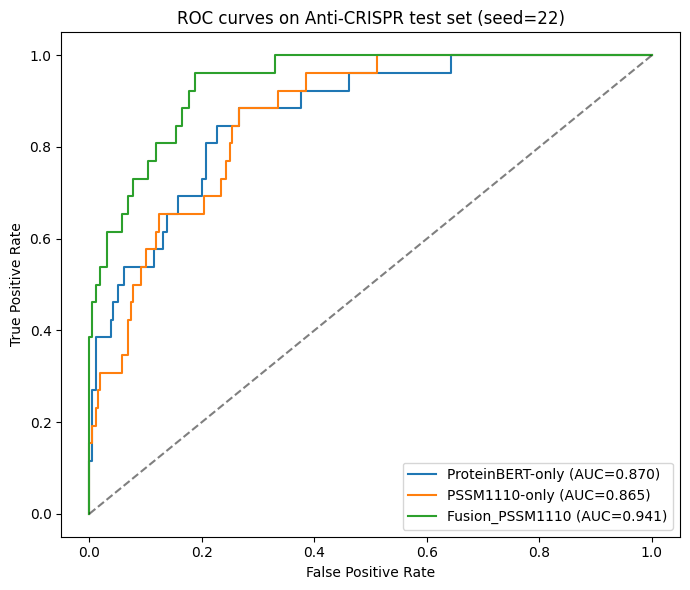

In [5]:
fpr_prot, tpr_prot, _ = roc_curve(y_test, y_prob_prot)
fpr_pssm, tpr_pssm, _ = roc_curve(y_test, y_prob_pssm)
fpr_fusion, tpr_fusion, _ = roc_curve(y_test, y_prob_fusion)

plt.figure(figsize=(7, 6))
plt.plot(fpr_prot, tpr_prot, label=f'ProteinBERT-only (AUC={auc_prot:.3f})')
plt.plot(fpr_pssm, tpr_pssm, label=f'PSSM1110-only (AUC={auc_pssm:.3f})')
plt.plot(fpr_fusion, tpr_fusion, label=f'Fusion_PSSM1110 (AUC={auc_fusion:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves on Anti-CRISPR test set (seed=22)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()